# 港股个股加权流动性

用聚源数据库港股行情数据计算港股各只股票Amihud流动性，再以一定权重加权得到港股流动性指标

In [32]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 读取成分股

In [68]:
INDEX_CODE = 'HSCEI'

In [69]:
comp_df = pd.read_excel('../data/components/%s.xlsx'%(INDEX_CODE), index_col=0)

In [70]:
comp_df.head()

,代码,简称,收盘(元),权重（%）↓,涨跌,涨跌幅(%),指数贡献点,成交量(万股),成交额(万元),总股本(亿股),自由流通股本(亿股),总市值(亿元),自由流通市值(亿元),证监会行业,Wind行业
排名,,,,,,,,,,,,,,,
1,6060.HK,众安在线,26.45,0.0,-0.45,-1.67,0.0,212.80,"5,657.39",--,4.40,388.77,--,NaN,金融
2,1109.HK,华润置地,25.15,0.0,-0.60,-2.33,0.0,"1,379.29","35,034.55",--,26.84,"1,743.13",--,房地产业,房地产
3,1093.HK,石药集团,15.18,0.0,-0.48,-3.07,0.0,"2,258.96","34,558.73",--,42.02,947.69,--,医药制造业,医疗保健
4,1044.HK,恒安国际,68.90,0.0,-2.10,-2.96,0.0,320.34,"22,330.82",--,7.30,830.98,--,综合,日常消费
5,0384.HK,中国燃气,21.70,0.0,-0.25,-1.14,0.0,"1,440.37","31,578.00",--,14.06,"1,102.65",--,燃气生产和供应业,公用事业


## 逐个访问数据库并提取历史行情

In [71]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=10.0.185.138;DATABASE=JYDB;UID=js_dev;PWD=js_dev')

In [72]:
dic = {}
for code in comp_df[u'代码']:
    jycode = '0' + code.rstrip('.HK')
    query = 'SELECT qt.TradingDay, qt.ClosePrice, qt.ChangePCT, qt.TurnoverVolume, t.SecuCode, t.SecuAbbr \
             FROM QT_HKDailyQuote as qt, HK_SecuMain as t \
             WHERE qt.InnerCode = t.InnerCode \
                AND t.SecuCode = \'%s\' \
                ORDER BY qt.TradingDay DESC'%(jycode)
    cur_df = pd.read_sql_query(query, con=conn)
    cur_df.set_index('TradingDay', inplace=True)
    dic[code] = cur_df['ChangePCT'].abs() * 1e8 / cur_df['TurnoverVolume']

In [73]:
df = pd.DataFrame(dic)

In [74]:
df = df.replace([-np.inf, np.inf], 0)

In [75]:
liquidity = df.mean(axis=1)
liquidity.to_excel('../data/liquidity/%s.xlsx'%(INDEX_CODE))

In [76]:
liquidity = liquidity[liquidity.index >= '2010-01-01']

<BarContainer object of 2160 artists>

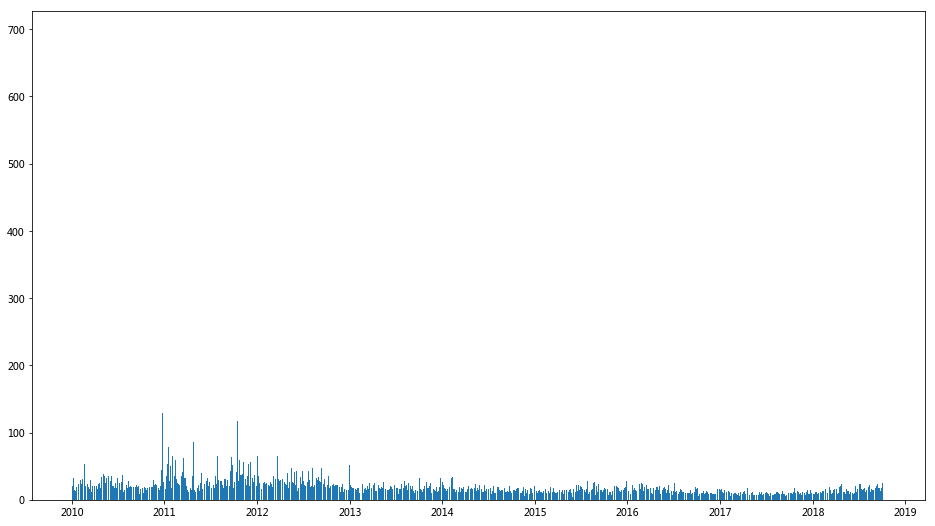

In [77]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(liquidity.index, liquidity, width=2)

In [78]:
z = liquidity.rolling(243).apply(lambda x: (x[-1] - x.mean()) / x.std())

In [79]:
z[z < 2] = 0

<BarContainer object of 2160 artists>

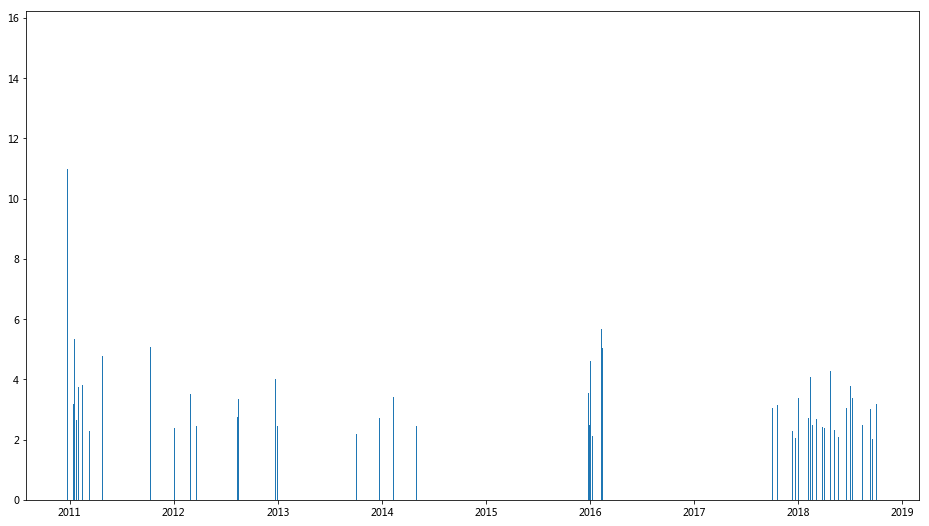

In [80]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(z.index, z, width=2)